# 数据集 Dataset
> 详见pytorch教程[Dataset & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

In [40]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## 数据集加载

使用**Mnist**数据集作为样例，介绍pytorch加载dataset的两种方法：
- `torchvision.datasets.MNIST`接口直接下载并加载MNIST数据集
- 使用`pip download安装包`，先下载好数据集后从本地加载数据集
### torchvision.datasets.MNIST
> 详见[MNIST](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html)

In [2]:
train_dataset = datasets.MNIST(root = './datasets', train = True,
                               transform = transforms.ToTensor(), download = True)

print(type(train_dataset))


<class 'torchvision.datasets.mnist.MNIST'>



### 本地下载数据集后从本地加载

上述方法因为是在国内下载数据集，有时速度会非常缓慢。另一种方法便是用`download`先提前在本地下载好数据集（这里用了华为云的资源），或是直接去官网下载，后加载进pytorch mnist dataset中。

该方法有两种可行的操作：
- 直接更改pytorch中的**mnist.py**，详见[pytorch如何加载本地的数据集（例如MNIST/CIFAR10）](https://blog.csdn.net/qq_35015757/article/details/106249853)
- 自定义数据集(详见[自定义数据集](#jump1))


In [3]:
# Download data from open datasets
from download import download

url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/" \
      "notebook/datasets/MNIST_Data.zip"
path = download(url, "./datasets", kind="zip", replace=False) 

Replace is False and data exists, so doing nothing. Use replace=True to re-download the data.


## 数据集迭代

这里先说pytorch和mindspore的第一个区别：pytorch创建出的Mnist数据集对象是可以用下标访问的，而mindspore的MnistDataset不可以，会出现`object is not subscriptable`的报错。

用`dir()`查了一下发现是因为没有私有函数`__getitem__`。

In [17]:
def visualize(dataset):
    figure = plt.figure(figsize=(4, 4))
    cols, rows = 3, 3
    for i in range(cols * rows):
        img, label = dataset[i]
        figure.add_subplot(rows, cols, i+1)
        plt.title(label)
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

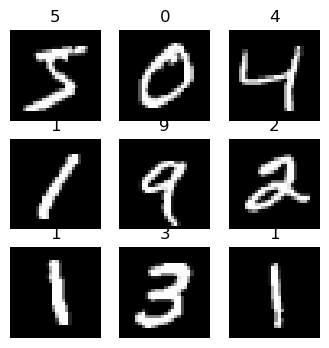

In [18]:
visualize(train_dataset)

第二个区别，mindspore使用的是数据集`create_tuple_iterator`或`create_dict_iterator`接口创建数据迭代器来迭代访问数据，对数据的`batch`，`shuffle`等操作是在dataset而不是iterator中进行。相比之下，pytorch是调用`DataLoader`创建迭代器，并在此时进行数据操作。

In [26]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=False)

In [29]:
def visualize_dataloader(data_loader):
    figure = plt.figure(figsize=(4, 4))
    cols, rows = 3, 3

    for idx, (image, label) in enumerate(data_loader):
        figure.add_subplot(rows, cols, idx + 1)
        plt.title(int(label))
        plt.axis("off")
        plt.imshow(image.squeeze(), cmap="gray")
        if idx == cols * rows - 1:
            break
    plt.show()

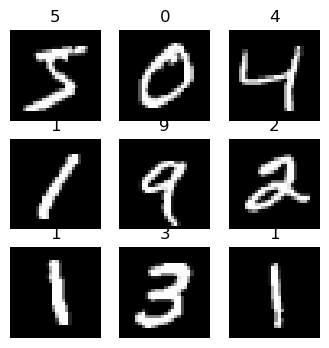

In [30]:
visualize_dataloader(train_dataloader)

## 数据集常用操作

pytorch中的数据集操作都是在`dataloader`中实现的，而在个人看来，mindspore采用`dataset = dataset.operation()`更多地是映射了tensorflow的API，可参考mindspore官网中与tensorflow API的映射表中的[tf.data表格](https://www.mindspore.cn/docs/zh-CN/r1.9/note/api_mapping/tensorflow_api_mapping.html?highlight=tensorflow#tf-data)


### shuffle

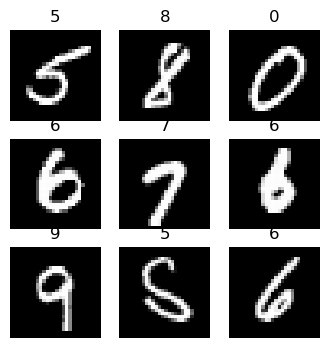

In [31]:
train_dataloader = DataLoader(train_dataset, shuffle=True)

visualize_dataloader(train_dataloader)

### map

在我理解看来，相比于mindspore和tensorflow的先创建一个原始dataset后进行数据变换的思想，pytorch遵从先将数据变换好再打包成dataset的思路。

所以在pytorch中能实现`map`最好的方法就是一开始在创建dataset时就对数据进行预处理。

不然先创建dataset，到后面再进行操作时，还需要把dataset拆开成images和labels，分别apply transforms，再把他们整合成dataset。听起来就很麻烦，何必不在最开始就一次性完成呢？

但这样相比起来，pytorch对数据预处理操作的灵活度就要逊色于mindspore了。

#### mindspore中的图像缩放处理

mindspore数据集image中的输出为28x28x1的Tensor，即图像大小为28x28，每个pixel中仅有一个值表示图像的intensity（0-255，格式为UInt8），后续还需要通过整体除以225来将数值从0-255变成0-1（格式为float32）。

pytorch直接输出的是已经“处理好”的图片，即1个batch下，图片是黑白所以channel数为1（另一种常见的格式是RGB，channel数为3），每张图片大小为28X28。每一个pixel的值在0-1之间，格式为float32。

这也是为什么mindspore中有`Rescale`的操作，而pytorch没有的原因。

In [37]:
image, label = next(iter(train_dataloader))
print(image.shape, image.dtype)

torch.Size([1, 1, 28, 28]) torch.float32


这里额外说一下pytorch中的`Tensor.size()`和mindspore中`Tensor.size`的区别。

mindspore的size是作为Tensor的**属性**，输出为`int`，表示Tensor中所有元素的个数。

而pytorch中的`size()`是一个函数方式，调用时返回为`torch.Size`的对象，表示Tensor的形状，输出为等价于`Tensor.shape`。

pytorch中如想获取Tensor中元素个数，应调用`Tensor.numel()`或`Tensor.nelement()`。

#### Resize

为了更直观地看出mindspore和pytorch对于数据变换上的区别，我们再尝试将数据集中的图片大小进行更改，把28x28的图片大小变为32x32

In [43]:
train_transformer = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor()
])
train_dataset = datasets.MNIST(root = './datasets', train = True,
                               transform = train_transformer, download = False)
train_dataloader = DataLoader(train_dataset, shuffle=True)
image, label = next(iter(train_dataloader))
print(image.shape, image.dtype)

torch.Size([1, 1, 32, 32]) torch.float32


### batch

这个功能可以再`dataloader`中实现，输出的数据在表示batch个数的第一维上由1变为64。

In [44]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
image, label = next(iter(train_dataloader))
print(image.shape, image.dtype)

torch.Size([64, 1, 32, 32]) torch.float32


## <span id="jump1">自定义数据集</span>

mindspore是先构造一个迭代器`Iterator`，后将迭代器加载入`GeneratorDataset`中。在pytorch中与之对应的便是`torch.utils.data.Dataset`，他们之间的对比可以参考mindspore官网中的[比较与torch.utils.data.Dataset的功能差异](https://www.mindspore.cn/docs/zh-CN/r1.9/note/api_mapping/pytorch_diff/GeneratorDataset.html)。

简单来说，pytorch在构建自定义数据集时继承了`Dataset`，但父类Dataset中的两个私有函数`__len__`和`__getitem__`必须重载。

In [45]:
import numpy as np

class CustomImageDataset(Dataset):
    def __init__(self, transform=None, target_transform=None):
        self._data = np.random.sample((5, 2))
        self._label = np.random.sample((5, 1))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self._data)

    def __getitem__(self, idx):
        image = self._data[idx]
        label = self._label[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

dataset = CustomImageDataset()

接下来我们尝试一下把之前下载再本地的Mnist数据集载入我们自定义的Dataset中。

In [74]:
import os
import os.path
import gzip
from PIL import Image
from torchvision.io import read_image


class CustomMnistDataset(Dataset):
    def __init__(self, root, transform=None, target_transform=None):
        self.root = root
        self.raw_folder = os.path.join(self.root, "MNIST", "raw")
        self.transform = transform
        self.target_transform = target_transform
        self._data, self._label = self._load_data()
    
    def __len__(self):
        return len(self._data)

    def _load_data(self):
        label_file = "train-labels-idx1-ubyte.gz"
        with gzip.open(os.path.join(self.raw_folder, label_file), 'rb') as lbpath: # rb表示的是读取二进制数据
            label = np.frombuffer(lbpath.read(), np.uint8, offset=8)

        image_file = "train-images-idx3-ubyte.gz"
        with gzip.open(os.path.join(self.raw_folder, image_file), 'rb') as imgpath:
            data = np.frombuffer(
                imgpath.read(), np.uint8, offset=16).reshape(len(label), 28, 28)
            data = (data/256).astype(np.float32)
        return data, label

    def __getitem__(self, idx):  

        img, target = self._data[idx], int(self._label[idx])

        # img = Image.fromarray(img.numpy(), mode="L")
        # img = img/256.0

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

my_mnist_dataset = CustomMnistDataset(root='./datasets')

In [75]:
img, label = my_mnist_dataset[0]
print(img.shape, img.dtype)

(28, 28) float32


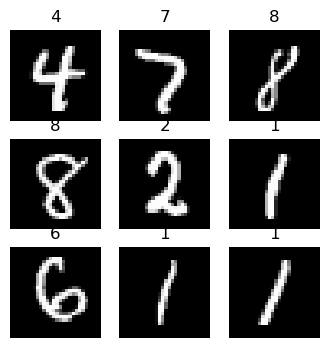

In [76]:
my_mnist_dataloader = DataLoader(my_mnist_dataset, shuffle=True)

visualize_dataloader(my_mnist_dataloader)